# Preprocessing and exploratory analysis to multiseq data

scanpy documentation: https://scanpy.readthedocs.io/en/stable/  
anndata documentation: https://anndata.readthedocs.io/en/stable/anndata.AnnData.html#anndata.AnnData


In [1]:
# Load modules
import scanpy as sc
import numpy as np
import pandas as pd 
import seaborn as sns

import os
import sys
import glob

sc.set_figure_params(dpi=200)
#sys.path.append('/public/groups/hausslerlab/people/sjhwang/multiseq/bin/scoreCT/src/')
#import scorect_api as ct
#sys.path.append('/public/groups/hausslerlab/people/sjhwang/multiseq/bin/sc_utils/')
#from cluster_enrichment import clusterEnrich

## Load data

https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/using/aggregate#csv_setup  
https://bioinformatics.stackexchange.com/questions/779/handling-sample-identity-in-aggregated-10x-libraries

In [4]:
# note... doesn't work bc key error

#mtx_directory = 'data/filtered_gene_bc_matrices/hg19/'
mtx_directory = '/home/stephen/Documents/classes/bme/230B/decon/PBMC_scRNA-seq_data/GSE132044_data/'

adata = sc.read_10x_mtx(
    mtx_directory,  # the directory with the `.mtx` file
    var_names='gene_symbols')                # use gene symbols for the variable names (variables-axis index)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

KeyError: 1

In [10]:
# Load PBMC data

# Load PBMC_6kv1_tpm.csv dataset with 5419 cells and 32738 genes. Datasets were preprocessed into log2-tpm space
# tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
data_dir = '/home/stephen/Documents/classes/bme/230B/decon/PBMC_scRNA-seq_data/tpm/'

adata1 = sc.read(data_dir + "PBMC_6kv1_tpm.csv").T
print(adata1.X.shape)
adata1

(5419, 32738)


AnnData object with n_obs × n_vars = 5419 × 32738

In [25]:
# Load PBMC data

# Load PBMC_6kv1_tpm.csv dataset with 5419 cells and 32738 genes. Datasets were preprocessed into log2-tpm space
# tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
data_dir = '/home/stephen/Documents/classes/bme/230B/decon/PBMC_scRNA-seq_data/tpm/'

adata2 = sc.read(data_dir + "PBMC_8kv2_tpm.csv").T
print(adata2.X.shape)
adata2

(8381, 33694)


AnnData object with n_obs × n_vars = 8381 × 33694

In [13]:
# Load PBMC data

# Load PBMC_6kv1_tpm.csv dataset with 5419 cells and 32738 genes. Datasets were preprocessed into log2-tpm space
# tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
data_dir = '/home/stephen/Documents/classes/bme/230B/decon/PBMC_scRNA-seq_data/tpm/'

adata3 = sc.read(data_dir + "PBMC_10kv3_tpm.csv").T
print(adata3.X.shape)
adata3

(7865, 33555)


AnnData object with n_obs × n_vars = 7865 × 33555

In [26]:
adata = adata2 #  PBMC_8kv2_tpm.csv
adata

AnnData object with n_obs × n_vars = 8381 × 33694

## Loading adata

## Pre-processing

Will filter out cells with more than 0.1 percent of mitochondrial genes
Will filter out cells with less than 200 and more than 6000 genes
Additional filtering: cells with less than  200 genes.
Additional filtering: genes expressed in less than  3 cells.


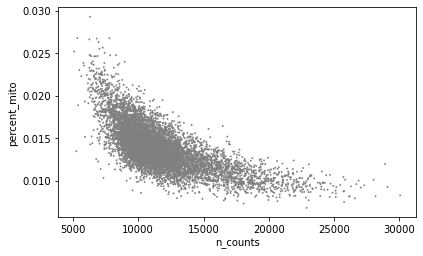

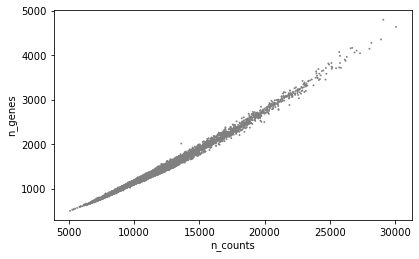

Scanpy: Filtering cells
Scanpy: Saving log data as raw
Scanpy: Normalization step
Scanpy: finding highly variable genes


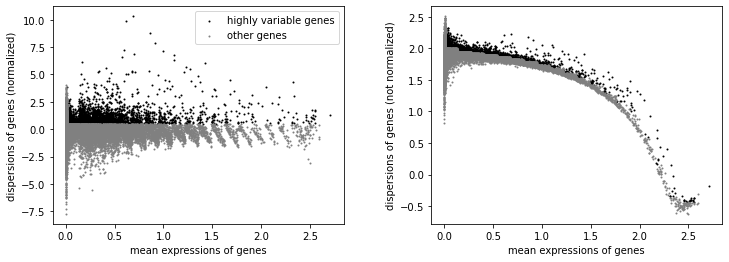

/home/stephen/anaconda3/envs/scRNA/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:343: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Scanpy: Regressing out variables
Number of variable genes identified: 3365


In [27]:
# Drop all var columns
adata.var = adata.var.drop(list(adata.var), axis=1)
adata.obs = adata.obs.loc[:, adata.obs.columns.notnull()]
#Basic filtering
min_gen = 200
min_cel = 3
thrsh_mito=0.1
up_thrsh_genes=6000
low_thrsh_genes=200    #200    # consider 500 or 700?

print("Will filter out cells with more than",thrsh_mito,"percent of mitochondrial genes")
print("Will filter out cells with less than", low_thrsh_genes, "and more than", up_thrsh_genes, "genes")
print('Additional filtering: cells with less than ', min_gen, 'genes.')
print('Additional filtering: genes expressed in less than ', min_cel, 'cells.')

sc.pp.filter_cells(adata, min_genes=min_gen)
sc.pp.filter_genes(adata, min_cells=min_cel)
#Computing percentage of mitochondrial genes
mito_genes = [name for name in adata.var_names if name.startswith('MT.') or name.startswith('MT-') or name.startswith('MT')]            ## check mitochondrial genes → names don't fully align, so force MT* filter
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = np.sum(adata.X, axis=1)

#Plot 
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

#Filtering out cells according to filter parameters
print('Scanpy: Filtering cells')
adata = adata[adata.obs['n_genes'] < up_thrsh_genes, :]
adata = adata[adata.obs['n_genes'] > low_thrsh_genes, :]
adata = adata[adata.obs['percent_mito'] < thrsh_mito, :]

#Get logarithmirized raw gene exression (BEFORE NORMALIZATION)
#for later use in differential gene expression search 
print('Scanpy: Saving log data as raw')
adata_raw = sc.pp.log1p(adata, copy=True)
adata.raw = adata_raw

#Per-cell normalization step, Identification of highly variable genes and filtering
#Normalize using 10000 as a factor
print('Scanpy: Normalization step')
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#Finding variable genes & filtering out others
print('Scanpy: finding highly variable genes')

filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

#Regress out variables nUMI and percent_mito, you can add 'batch' for BATCH CORRECTION (not useful here)
print('Scanpy: Regressing out variables')

sc.pp.regress_out(adata, ['n_counts','percent_mito'])
#Print number of highly variable genes
print('Number of variable genes identified:', sum(filter_result.gene_subset))


In [28]:
adata # 8381 × 3365 from 8381 × 18340

AnnData object with n_obs × n_vars = 8381 × 3365
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'

In [38]:
#T Cell marker CD3E+, B Cell marker CD19+, Monocyte marker CD14+, Natural Killer Cell marker FCGR3A+, Dendritic Cell marker ITGAX+, ITGAM+
#sc.pl.umap(adata, color=['louvain','CD3E','MS4A1','CD14','FCGR3A','ITGAX','ITGAM'],legend_loc='on data') 

# ITGAX not present
'ITGAX' in list(adata.var_names)
'ITGAX' in list(adata2.var_names)

False

Scanpy: Scaling data
Scanpy: Performing PCA with 100PCs


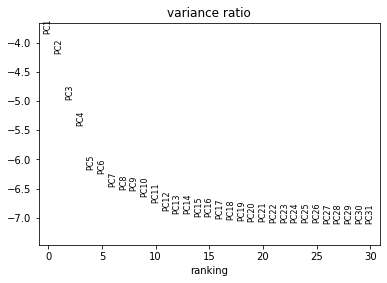

In [39]:
#Scaling after regression , before DimRed steps
print('Scanpy: Scaling data')

sc.pp.scale(adata, max_value=10)
#Linear dimension reduction using PCA
PCA_COMP = 100
print('Scanpy: Performing PCA with '+str(PCA_COMP)+'PCs')
logging.info("Scanpy: Performing PCA with %d PCs", PCA_COMP)

sc.tl.pca(adata, n_comps=PCA_COMP)
#Multiply by -1 to compare with Seurat
adata.obsm['X_pca'] *= -1
#Plot of pca variance ratio to see if formula matches visual determination of pc_nb to use
sc.pl.pca_variance_ratio(adata, log=True )

In [40]:
# Number of PCs to be used in clustering
pc_nb=15  # previous 25
print(pc_nb,' PCs will be used for UMAP and clustering')

15  PCs will be used for UMAP and clustering


In [41]:
#Neighbors and clustering
#Clustering. Default Resolution: 4
N_NEIGH = 10
print('Scanpy: Performing Louvain Clustering with', N_NEIGH, 'neighbors.')
logging.info("Scanpy: Performing Louvain Clustering %s neighbors.", N_NEIGH)

sc.pp.neighbors(adata, n_neighbors = N_NEIGH)
resol_clust = 1.0
sc.tl.louvain(adata, resolution=resol_clust)
print('Clustering resolution: ', resol_clust)
logging.info("NClustering resolution: %s", resol_clust)

#UMAP viz  colored by clusters and batches
sc.tl.umap(adata)

Scanpy: Performing Louvain Clustering with 10 neighbors.
Clustering resolution:  1.0


In [42]:
adata

AnnData object with n_obs × n_vars = 8381 × 3365
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'louvain', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [44]:
# Print final dimensions
print('Final dimensions:',len(adata.obs),' cells and ',len(adata.var),' HV genes.')
adata

Final dimensions: 8381  cells and  3365  HV genes.


AnnData object with n_obs × n_vars = 8381 × 3365
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'louvain', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

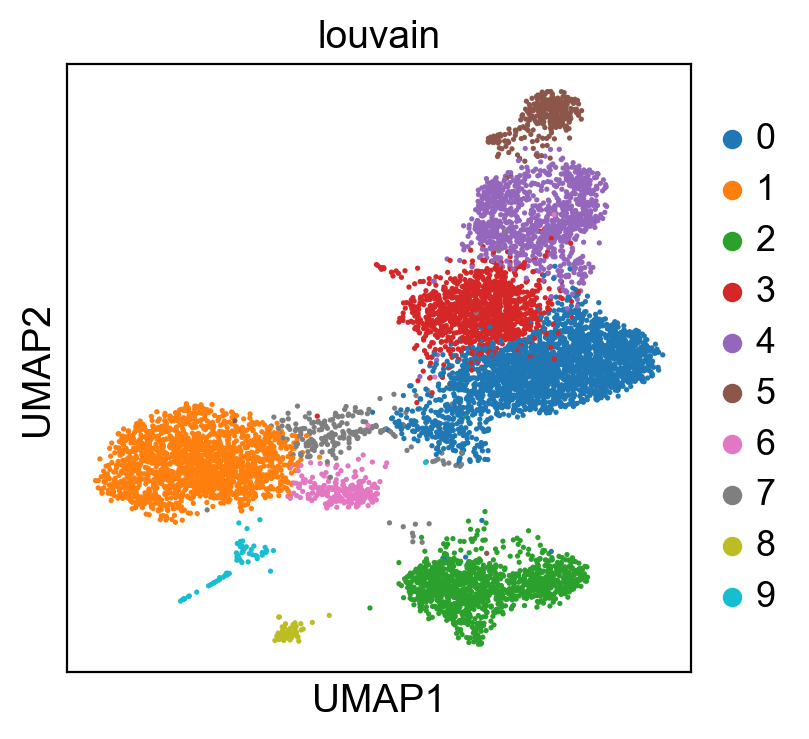

In [52]:
adata.obs['louvain'] = adata.obs['louvain'].astype('category')
sc.pl.umap(adata, color='louvain') # genotype sample

In [47]:
savePath = '/home/stephen/Documents/classes/bme/230B/decon/analysis/'
# PBMC_8kv2_tpm
# PBMC_10kv3_tpm
# PBMC_6kv1_tpm
#adata = sc.read(savePath + '/PBMC_8kv2_tpm.h5') 
adata.write(savePath + '/PBMC_8kv2_tpm.h5')
adata

AnnData object with n_obs × n_vars = 8381 × 3365
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'louvain', 'umap', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Annotation
Annotation of data using cell markers
https://www.abcam.com/primary-antibodies/t-cells-basic-immunophenotyping


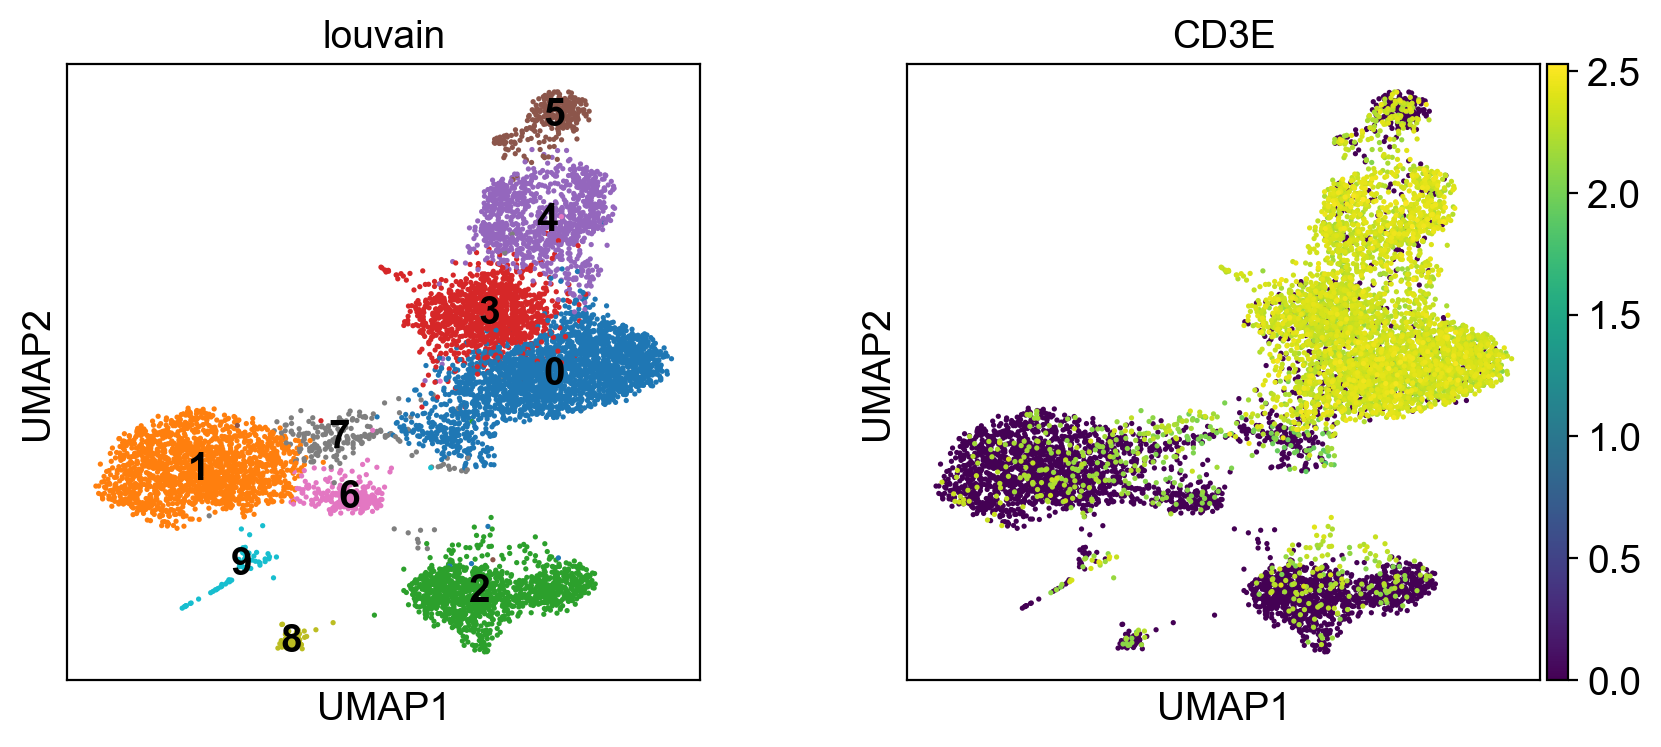

In [53]:
# T Cell marker CD3E+
sc.pl.umap(adata, color=['louvain','CD3E'],legend_loc='on data')

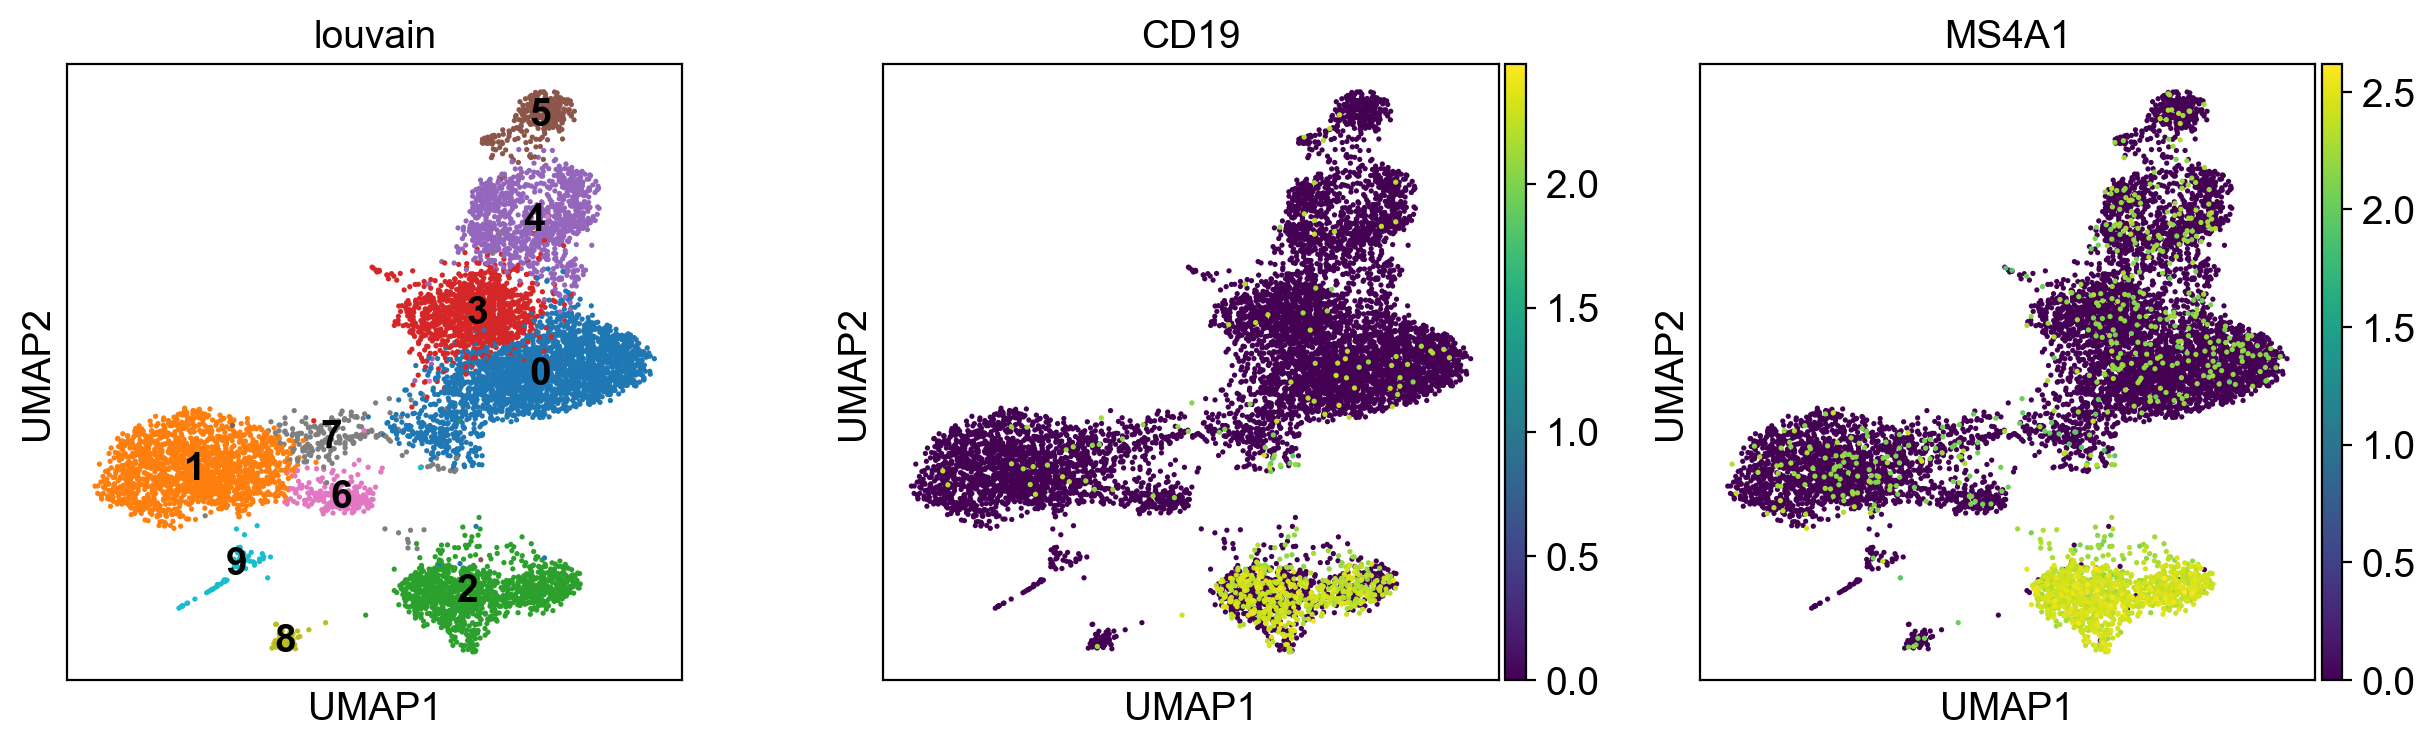

In [59]:
# B Cell marker CD19+
sc.pl.umap(adata, color=['louvain','CD19', 'MS4A1'],legend_loc='on data')

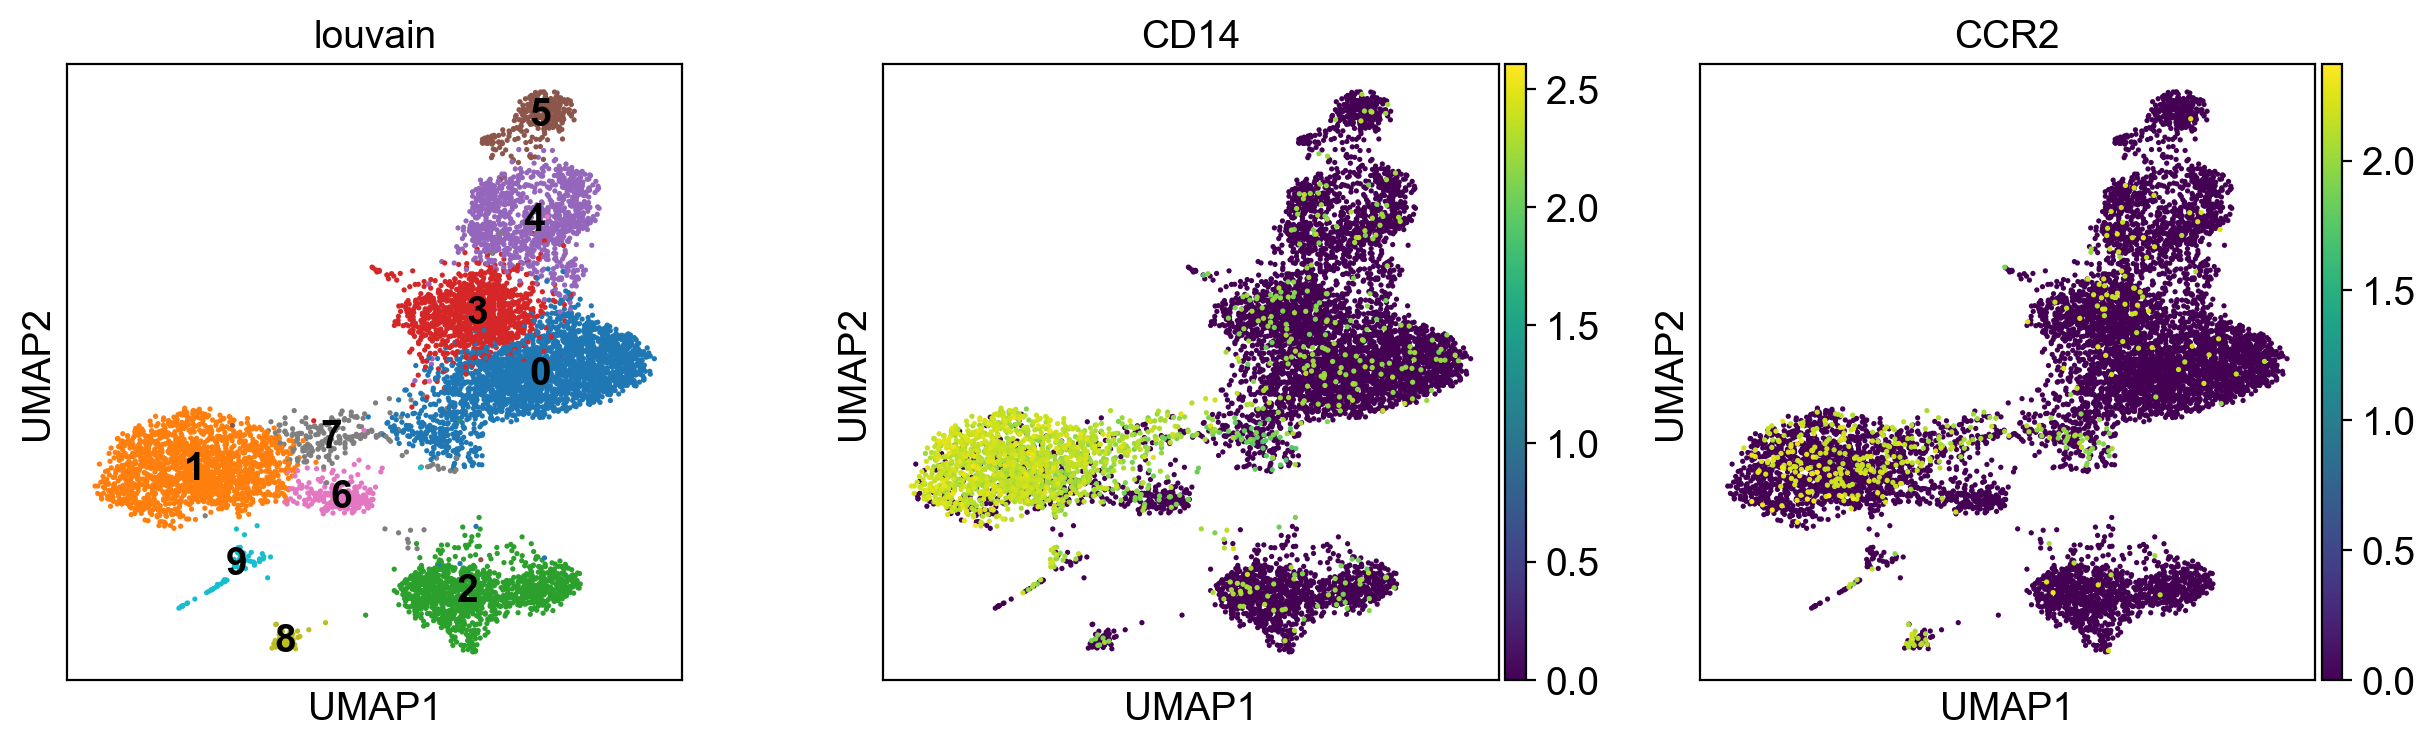

In [68]:
# Monocyte marker CD14+
# https://www.frontiersin.org/articles/10.3389/fimmu.2019.02035/full
# CD14, CD11b, CCR2, and CD16
sc.pl.umap(adata, color=['louvain', 'CD14', 'CCR2'],legend_loc='on data')

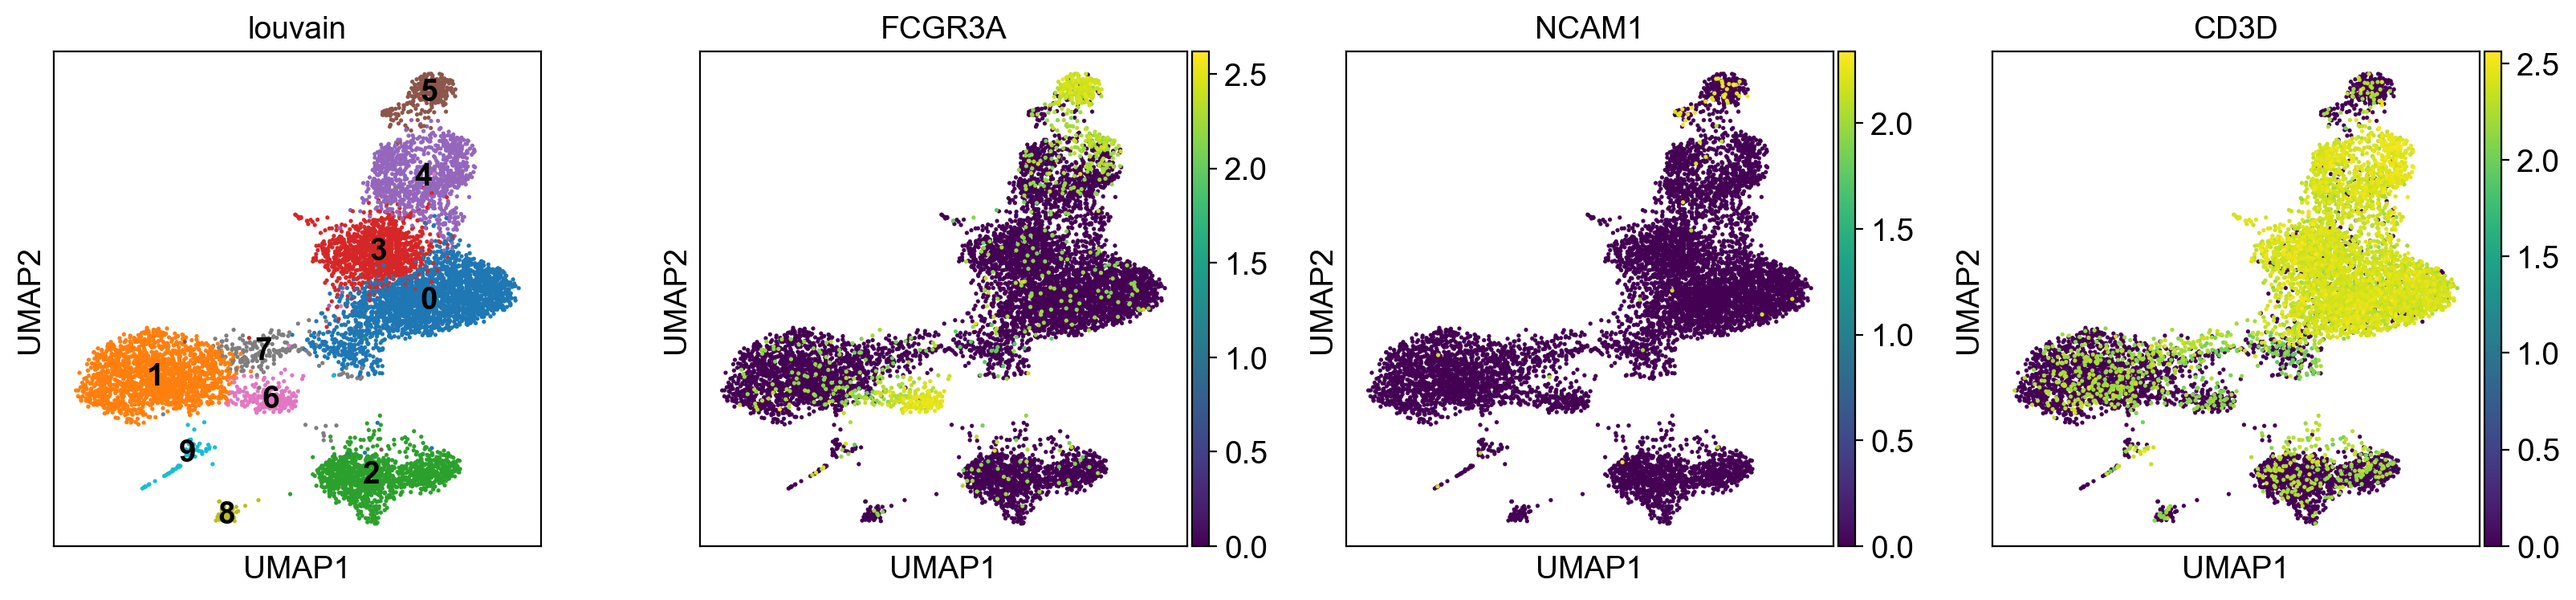

In [65]:
# Natural Killer Cell marker FCGR3A+, CD56+ (NCAM1), CD3−
sc.pl.umap(adata, color=['louvain','FCGR3A', 'NCAM1', 'CD3D', 'T3D'],legend_loc='on data')

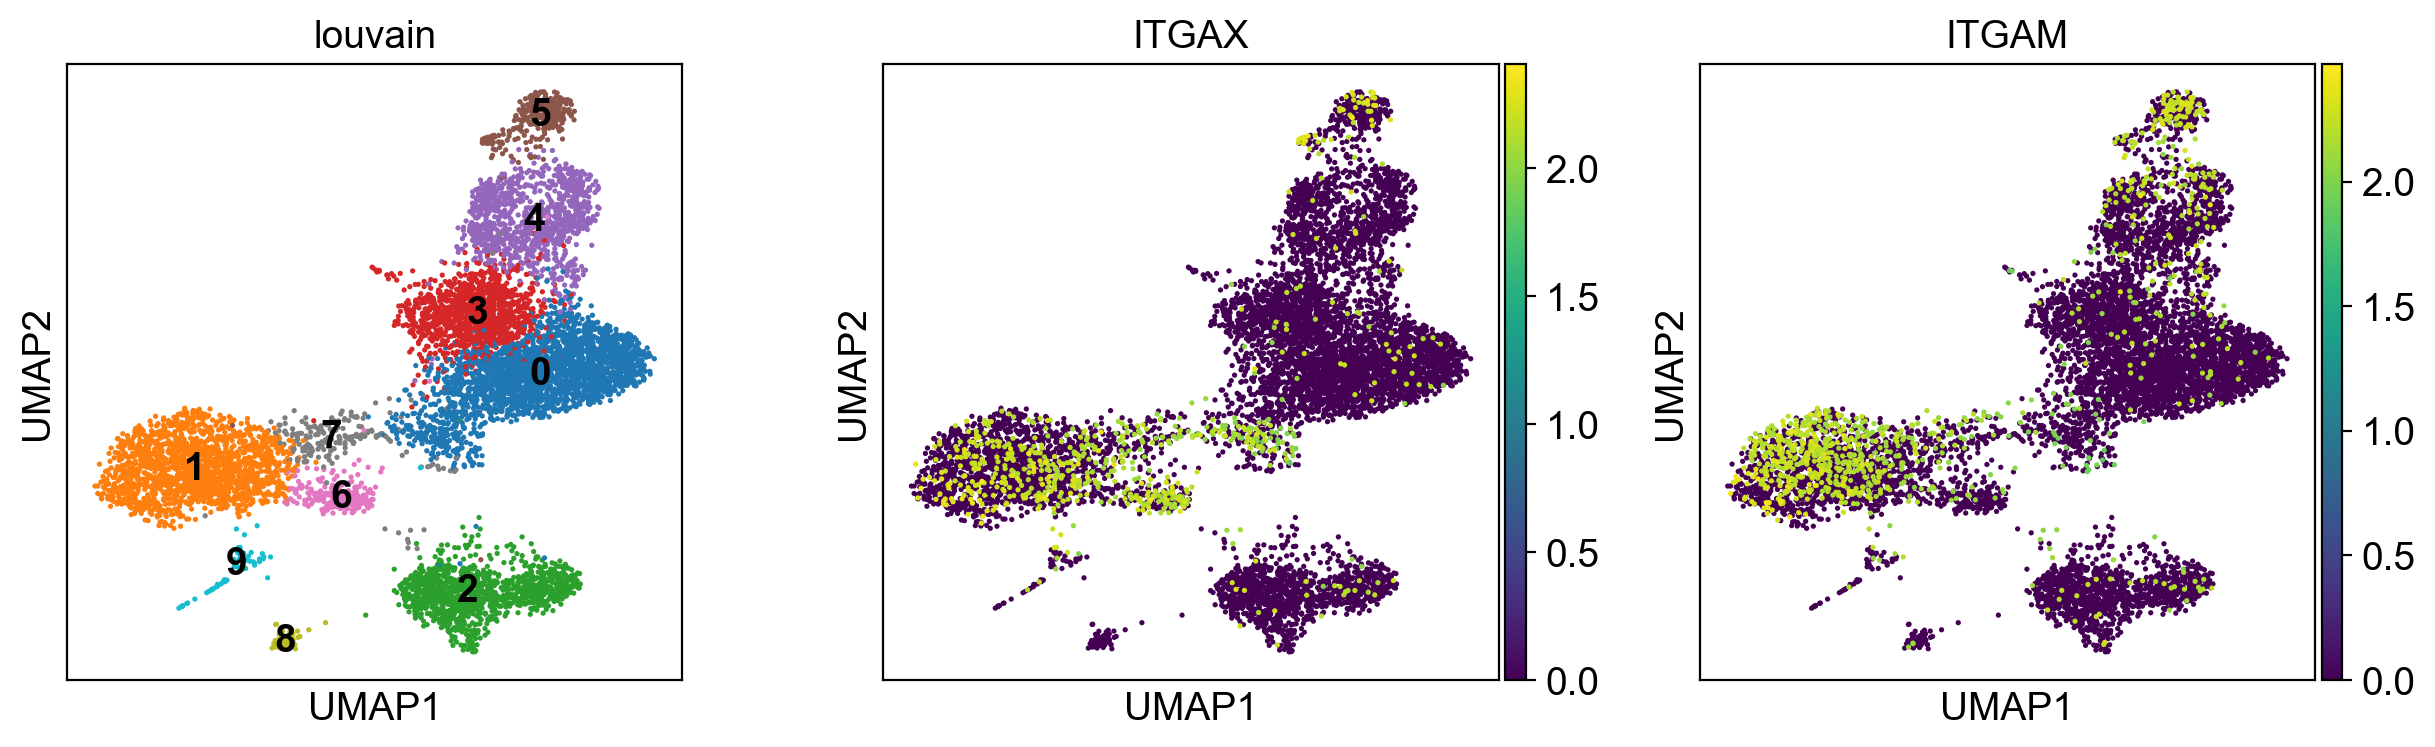

In [57]:
# Dendritic Cell marker ITGAX+, ITGAM+
sc.pl.umap(adata, color=['louvain','ITGAX','ITGAM'],legend_loc='on data')

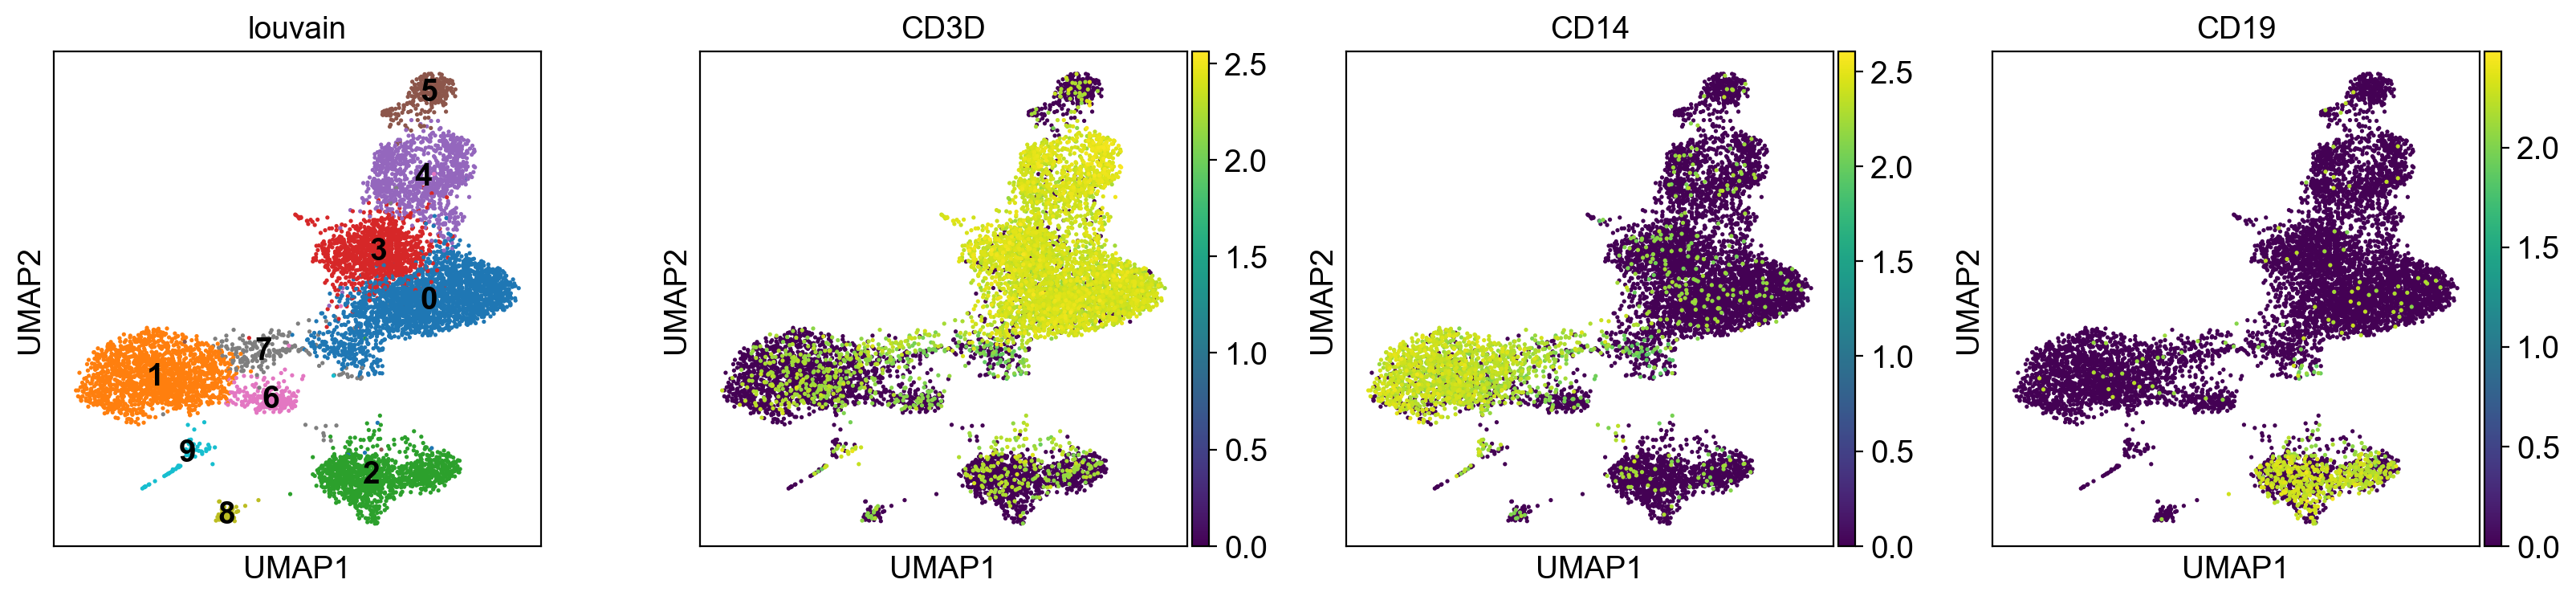

In [79]:
# Dendritic Cell marker absence CD3-, CD14-, CD19-, CD56-, CD66b-
sc.pl.umap(adata, color=['louvain','CD3D', 'CD14', 'CD19'],legend_loc='on data')

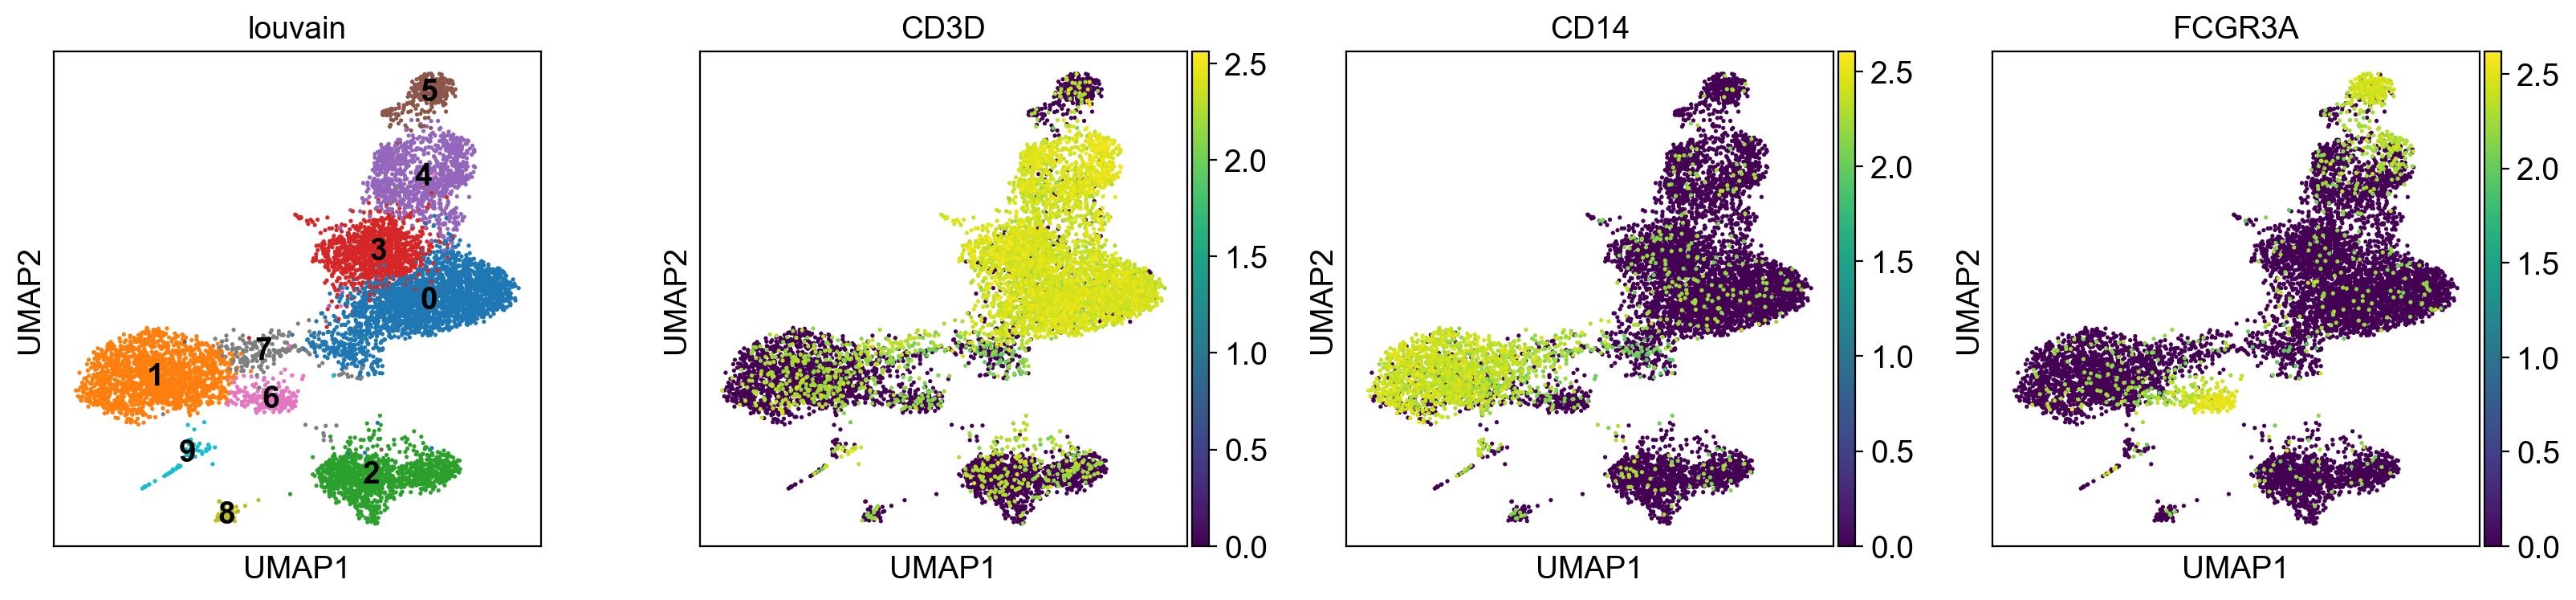

In [90]:
# FCGR3A == CD16
sc.pl.umap(adata, color=['louvain','CD3D', 'CD14', 'FCGR3A'],legend_loc='on data')

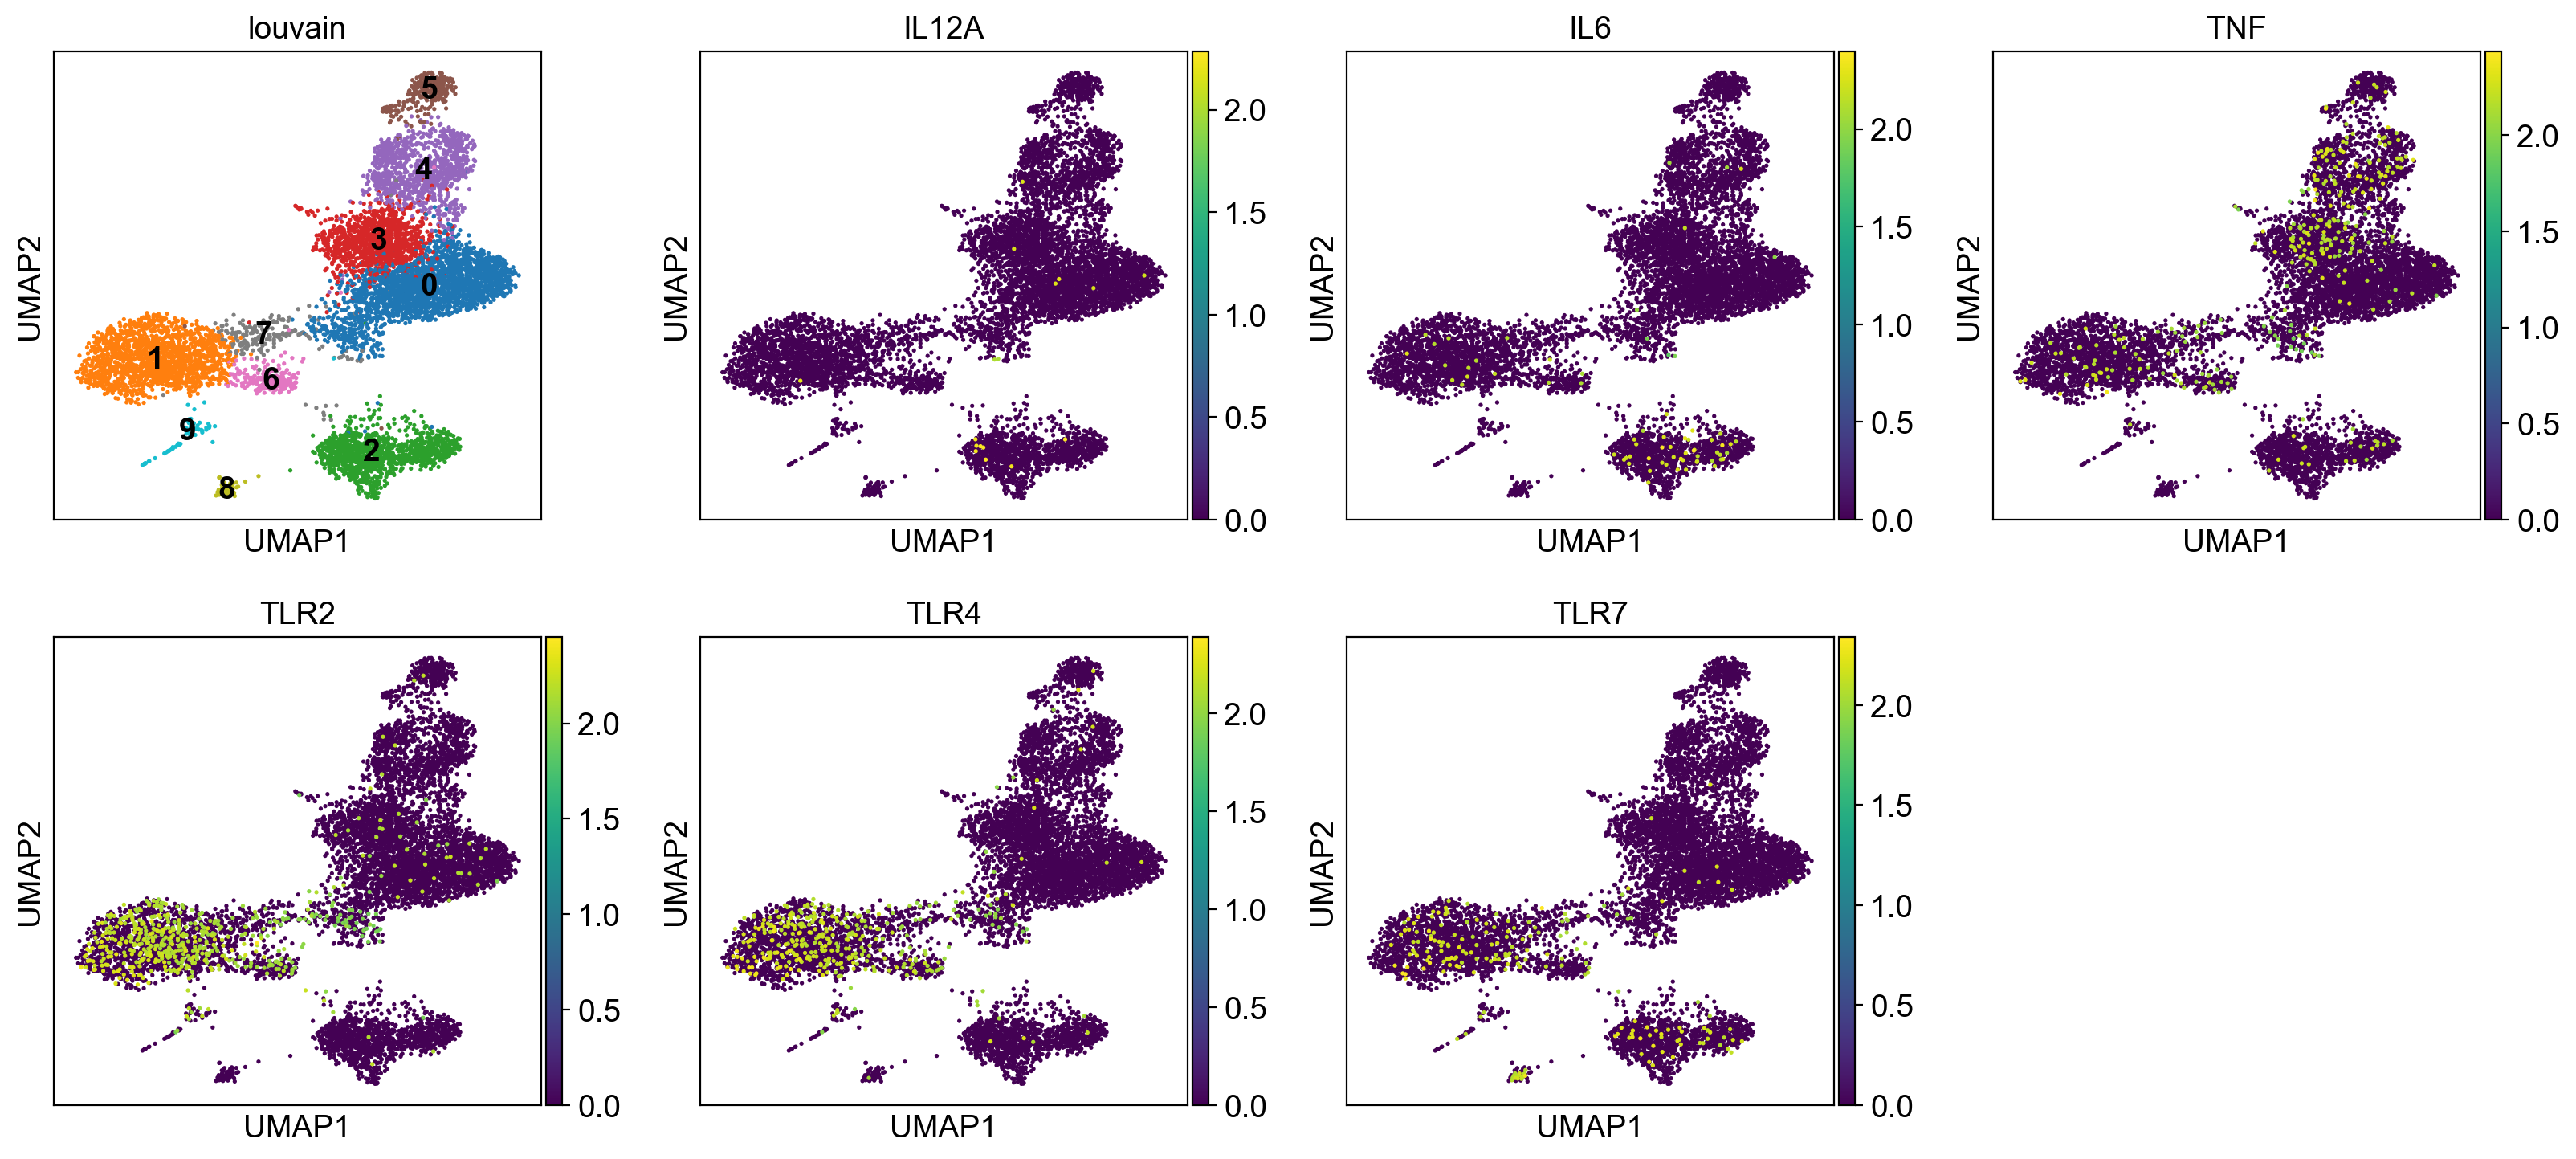

In [102]:
# Dendritic Cell marker absence CD3-, CD14-, CD19-, CD56-, CD66b-
sc.pl.umap(adata, color=['louvain', 'IL12A', 'IL6', 'TNF', 'TLR2', 'TLR4', 'TLR7'],legend_loc='on data')

In [103]:
# Cell type assignments
assign_cell = {'0': 'T cell',
               '1': 'Monocyte',
               '2': 'B cell',
               '3': 'T cell',
               '4': 'T cell',
               '5': 'NK cell',
               '6': 'Dendritic cell', # unknown
               '7': 'Dendritic cell', # unknown
               '8': 'unknown',
               '9': 'unknown'}

In [104]:
#identify cell type clusters by marker genes and assign cell types in adata object
adata.obs['cells'] = adata.obs['louvain']
adata.obs.replace({'cells': assign_cell},inplace=True)

# Make signature matrix

Steps:  
  - Differentially test expression (one vs rest)
  - filter for genes with q value <0.3
  - build sig matrix off this

Cibersort:
Significantly differentially expressed genes between each population and all other populations were identified using a two-sided unequal variance t-test. Genes with a q value <0.3 (false discovery rate) were considered significant.
 








### Example signature matrices

In [252]:
LM5_signature = pd.read_csv('/home/stephen/Documents/classes/bme/230B/decon/signature_matrix/LM5.txt', sep='\t', index_col=0)
LM5_genes = set(LM5_signature.index)
LM5_signature

avg_B cell  avg_NK cell  avg_T cell  avg_Monocyte  \
Gene symbol                                                      
ABCB4        555.713449    13.682839    7.406442      6.202496   
ABCB9         15.603544    21.863723   30.048192     20.309426   
ACAP1        215.305951   512.636909  922.152747    190.879024   
ACHE          15.117949    16.653738   18.444927     16.375268   
ACP5         605.897384   340.820137  557.819820    512.931382   
...                 ...          ...         ...           ...   
ZNF204P       77.876897    37.013302  168.895130     29.909746   
ZNF222         9.800664    92.278822   15.081330     19.860610   
ZNF286A      737.859904   225.407701  169.313128     11.043937   
ZNF324        28.211994    44.941180   27.169127     28.714449   
ZNF442        19.713197    21.770151    9.182954     12.300229   

             avg_Dendritic cell  
Gene symbol                      
ABCB4                  4.872184  
ABCB9                 23.384603  
ACAP1                 26.412923  
ACHE                 193.159977  
ACP5                3989.865169  
...                         ...  
ZNF204P               36.165940  
ZNF222                39.918349  
ZNF286A              280.769931  
ZNF324                23.836519  
ZNF442                96.008674  

[547 rows x 5 columns]

In [267]:
eg_signature = pd.read_csv('/home/stephen/Documents/classes/bme/230B/decon/signature_matrix/PBMC_example_signature_matrix_v1.tsv', sep='\t', index_col=0)
eg_genes = set(eg_signature.index)
eg_signature

avg_B cell  avg_NK cell  avg_T cell  avg_Monocyte  \
HES4             0.030047     2.358588    0.052116      0.216464   
MIB2             0.181869     1.008568    0.561580      0.151591   
RP3.395M20.12    0.278670     1.090962    0.355108      0.538996   
RPL22            6.829825     5.682169    7.395727      5.749610   
RBP7             0.013464     0.644222    0.009233      2.928134   
...                   ...          ...         ...           ...   
U2AF1            3.379163     4.314788    3.325055      3.643496   
SUMO3            1.140051     2.481517    1.498981      2.132281   
ITGB2            1.435451     7.845510    3.043520      5.670672   
S100B            0.000000     0.771351    0.270125      0.027622   
MT.ND1           9.877274    10.378896    9.925881     11.265939   

               avg_Dendritic cell  
HES4                     0.231184  
MIB2                     0.389044  
RP3.395M20.12            0.304109  
RPL22                    9.059103  
RBP7                     0.000000  
...                           ...  
U2AF1                    6.378678  
SUMO3                    4.061832  
ITGB2                    6.296577  
S100B                    0.251584  
MT.ND1                  10.685092  

[664 rows x 5 columns]

### Calculate DE genes

In [122]:
cell_types = set(['B cell', 'Dendritic cell', 'Monocyte', 'NK cell', 'T cell'])
cell_types

{'B cell', 'Dendritic cell', 'Monocyte', 'NK cell', 'T cell'}

In [123]:
sc.tl.rank_genes_groups(adata, 
                        groupby='cells',
                        groups=['B cell', 'Dendritic cell', 'Monocyte', 'NK cell', 'T cell'],
                        method='wilcoxon',
                        reference='rest',
                        key_added = "wilcoxon")

... storing 'cells' as categorical


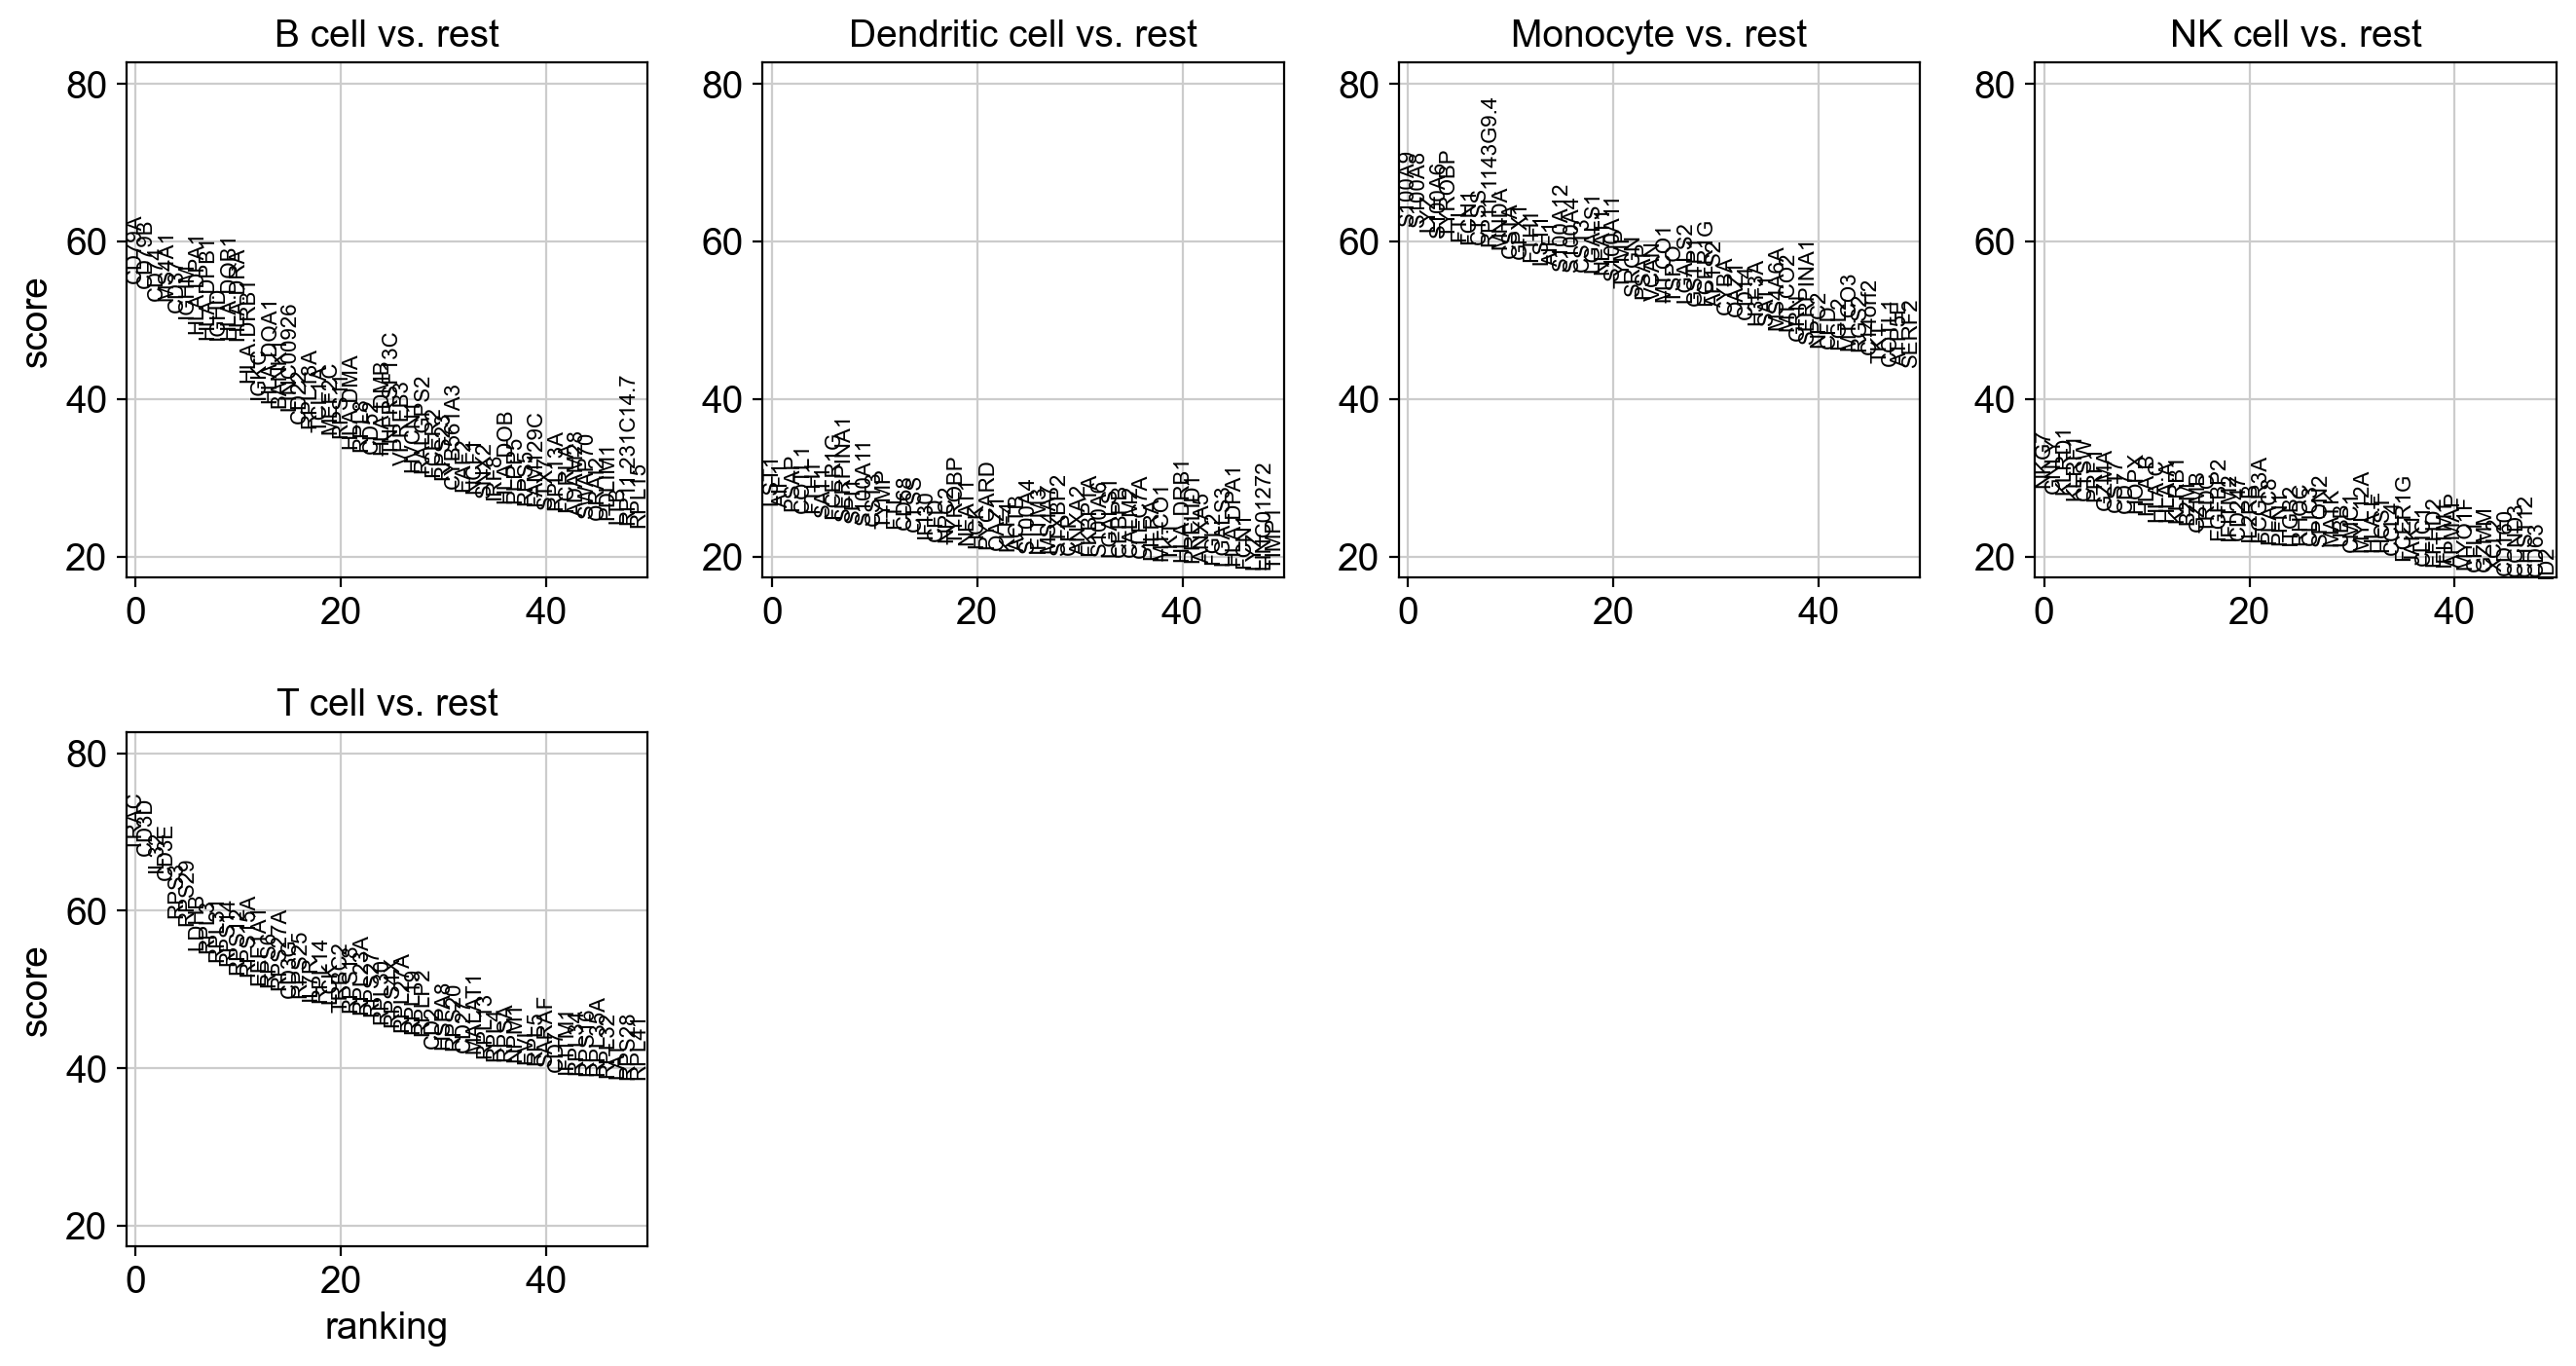

In [125]:
sc.pl.rank_genes_groups(adata, key="wilcoxon", n_genes=50)

In [289]:
adata.uns['wilcoxon']['logfoldchanges']

rec.array([( 5.39892   ,  2.6210487 ,  1.9714786 ,  3.5237648 ,  3.4308112 ),
           ( 4.386941  ,  2.6501286 ,  2.3856869 ,  4.359675  ,  3.6622353 ),
           ( 0.7637147 ,  1.7124071 ,  2.1332917 ,  5.047115  ,  3.12522   ),
           ...,
           (-1.5228945 , -0.09612459, -0.16113591, -0.13458955, -2.5396917 ),
           (-0.07672195, -0.0881969 , -0.16243535, -0.14922832, -0.78425014),
           (-3.4182143 , -0.07974677, -0.16476686, -0.17996031, -1.9985245 )],
          dtype=[('B cell', '<f4'), ('Dendritic cell', '<f4'), ('Monocyte', '<f4'), ('NK cell', '<f4'), ('T cell', '<f4')])

In [206]:
p_vals_df = pd.DataFrame(adata.uns['wilcoxon']['pvals_adj'])
p_vals = pd.DataFrame(adata.uns['wilcoxon']['pvals_adj']).to_numpy()
p_vals.shape
#p_vals_df

(18340, 5)

### Select gene features

In [314]:
## Filter for fold change and p-value

#pval_threshold = 0.3
#pval_threshold = 1e-12   # BH corrected p-values
pval_threshold = 0.05     # BH corrected p-values
fc_threshold = 3        # log fold change


sig_genes = set()
for idx, gtype in enumerate(cell_types):
  
    genes = [gene[idx] for gene in adata.uns['wilcoxon']['names']]
    p_values = [gene[idx] for gene in adata.uns['wilcoxon']['pvals_adj']]
    fold_change = [gene[idx] for gene in adata.uns['wilcoxon']['logfoldchanges']]
    gene_p_val = list(zip(genes, p_values, fold_change))

    #sig_genes = [(gene, pval) for gene, pval in gene_p_val if pval <= pval_threshold]
    tmp_sig_genes = [gene for gene, pval, fc in gene_p_val if pval <= pval_threshold and abs(fc) >= fc_threshold]
    sig_genes.update(tmp_sig_genes)
    print(gtype+': ', len(sig_genes) / len(genes))
    
print('\nSig genes:', len(sig_genes)) # ideally around 550-600 genes

NK cell:  0.015921483097055617
Monocyte:  0.019683751363140677
B cell:  0.03353326063249727
Dendritic cell:  0.03751363140676118
T cell:  0.04051254089422028

Sig genes: 743


In [315]:
print('sig threshold:', pval_threshold)
print('Mine only:', len(sig_genes - LM5_genes), '/', len(sig_genes))
print('Miss LM22:', len(LM5_genes - sig_genes), '/', len(LM5_genes))
print('Overap:', len(sig_genes) - len(sig_genes - LM5_genes))

sig threshold: 0.05
Mine only: 567 / 743
Miss LM22: 371 / 547
Overap: 176


In [316]:
print('sig threshold:', pval_threshold)
print('Mine only:', len(sig_genes - eg_genes), '/', len(sig_genes))
print('Miss eg.:', len(eg_genes - sig_genes), '/', len(eg_genes))
print('Overap:', len(sig_genes) - len(sig_genes - eg_genes))

sig threshold: 0.05
Mine only: 536 / 743
Miss eg.: 457 / 664
Overap: 207


### Create signature matrix

In [404]:
# average expression across annotation for raw data
res = pd.DataFrame(columns=adata.raw.var_names, index=adata.obs['cells'].cat.categories)                                                                                                 

for clust in adata.obs.cells.cat.categories: 
    res.loc[clust] = adata[adata.obs['cells'].isin([clust]),:].raw.X.mean(0)

# make sig matrix
sig_matrix = res[[*sig_genes]].drop(['unknown'],axis=0).T
sig_matrix.columns = ["avg_" + cluster for cluster in sig_matrix.columns]
sig_matrix = sig_matrix.astype(float)
sig_matrix.head()

avg_B cell  avg_Dendritic cell  avg_Monocyte  avg_NK cell  \
LINC00402    0.021371            0.055209      0.018057     0.014306   
LINC01272    0.033865            1.441197      0.996598     0.050930   
KLRG1        0.083777            0.178874      0.056272     1.092691   
SH2D1B       0.005376            0.196489      0.011657     0.803804   
GLT1D1       0.006922            0.091641      0.230448     0.029268   

           avg_T cell  
LINC00402    0.192972  
LINC01272    0.060833  
KLRG1        0.522019  
SH2D1B       0.014308  
GLT1D1       0.006924

In [405]:
# save signature matrix to a tsv file
sig_matrix_dir = "/home/stephen/Documents/classes/bme/230B/decon/signature_matrix/"
sig_matrix.to_csv(sig_matrix_dir+'signature_1.txt',sep='\t')

### plot signature matrix

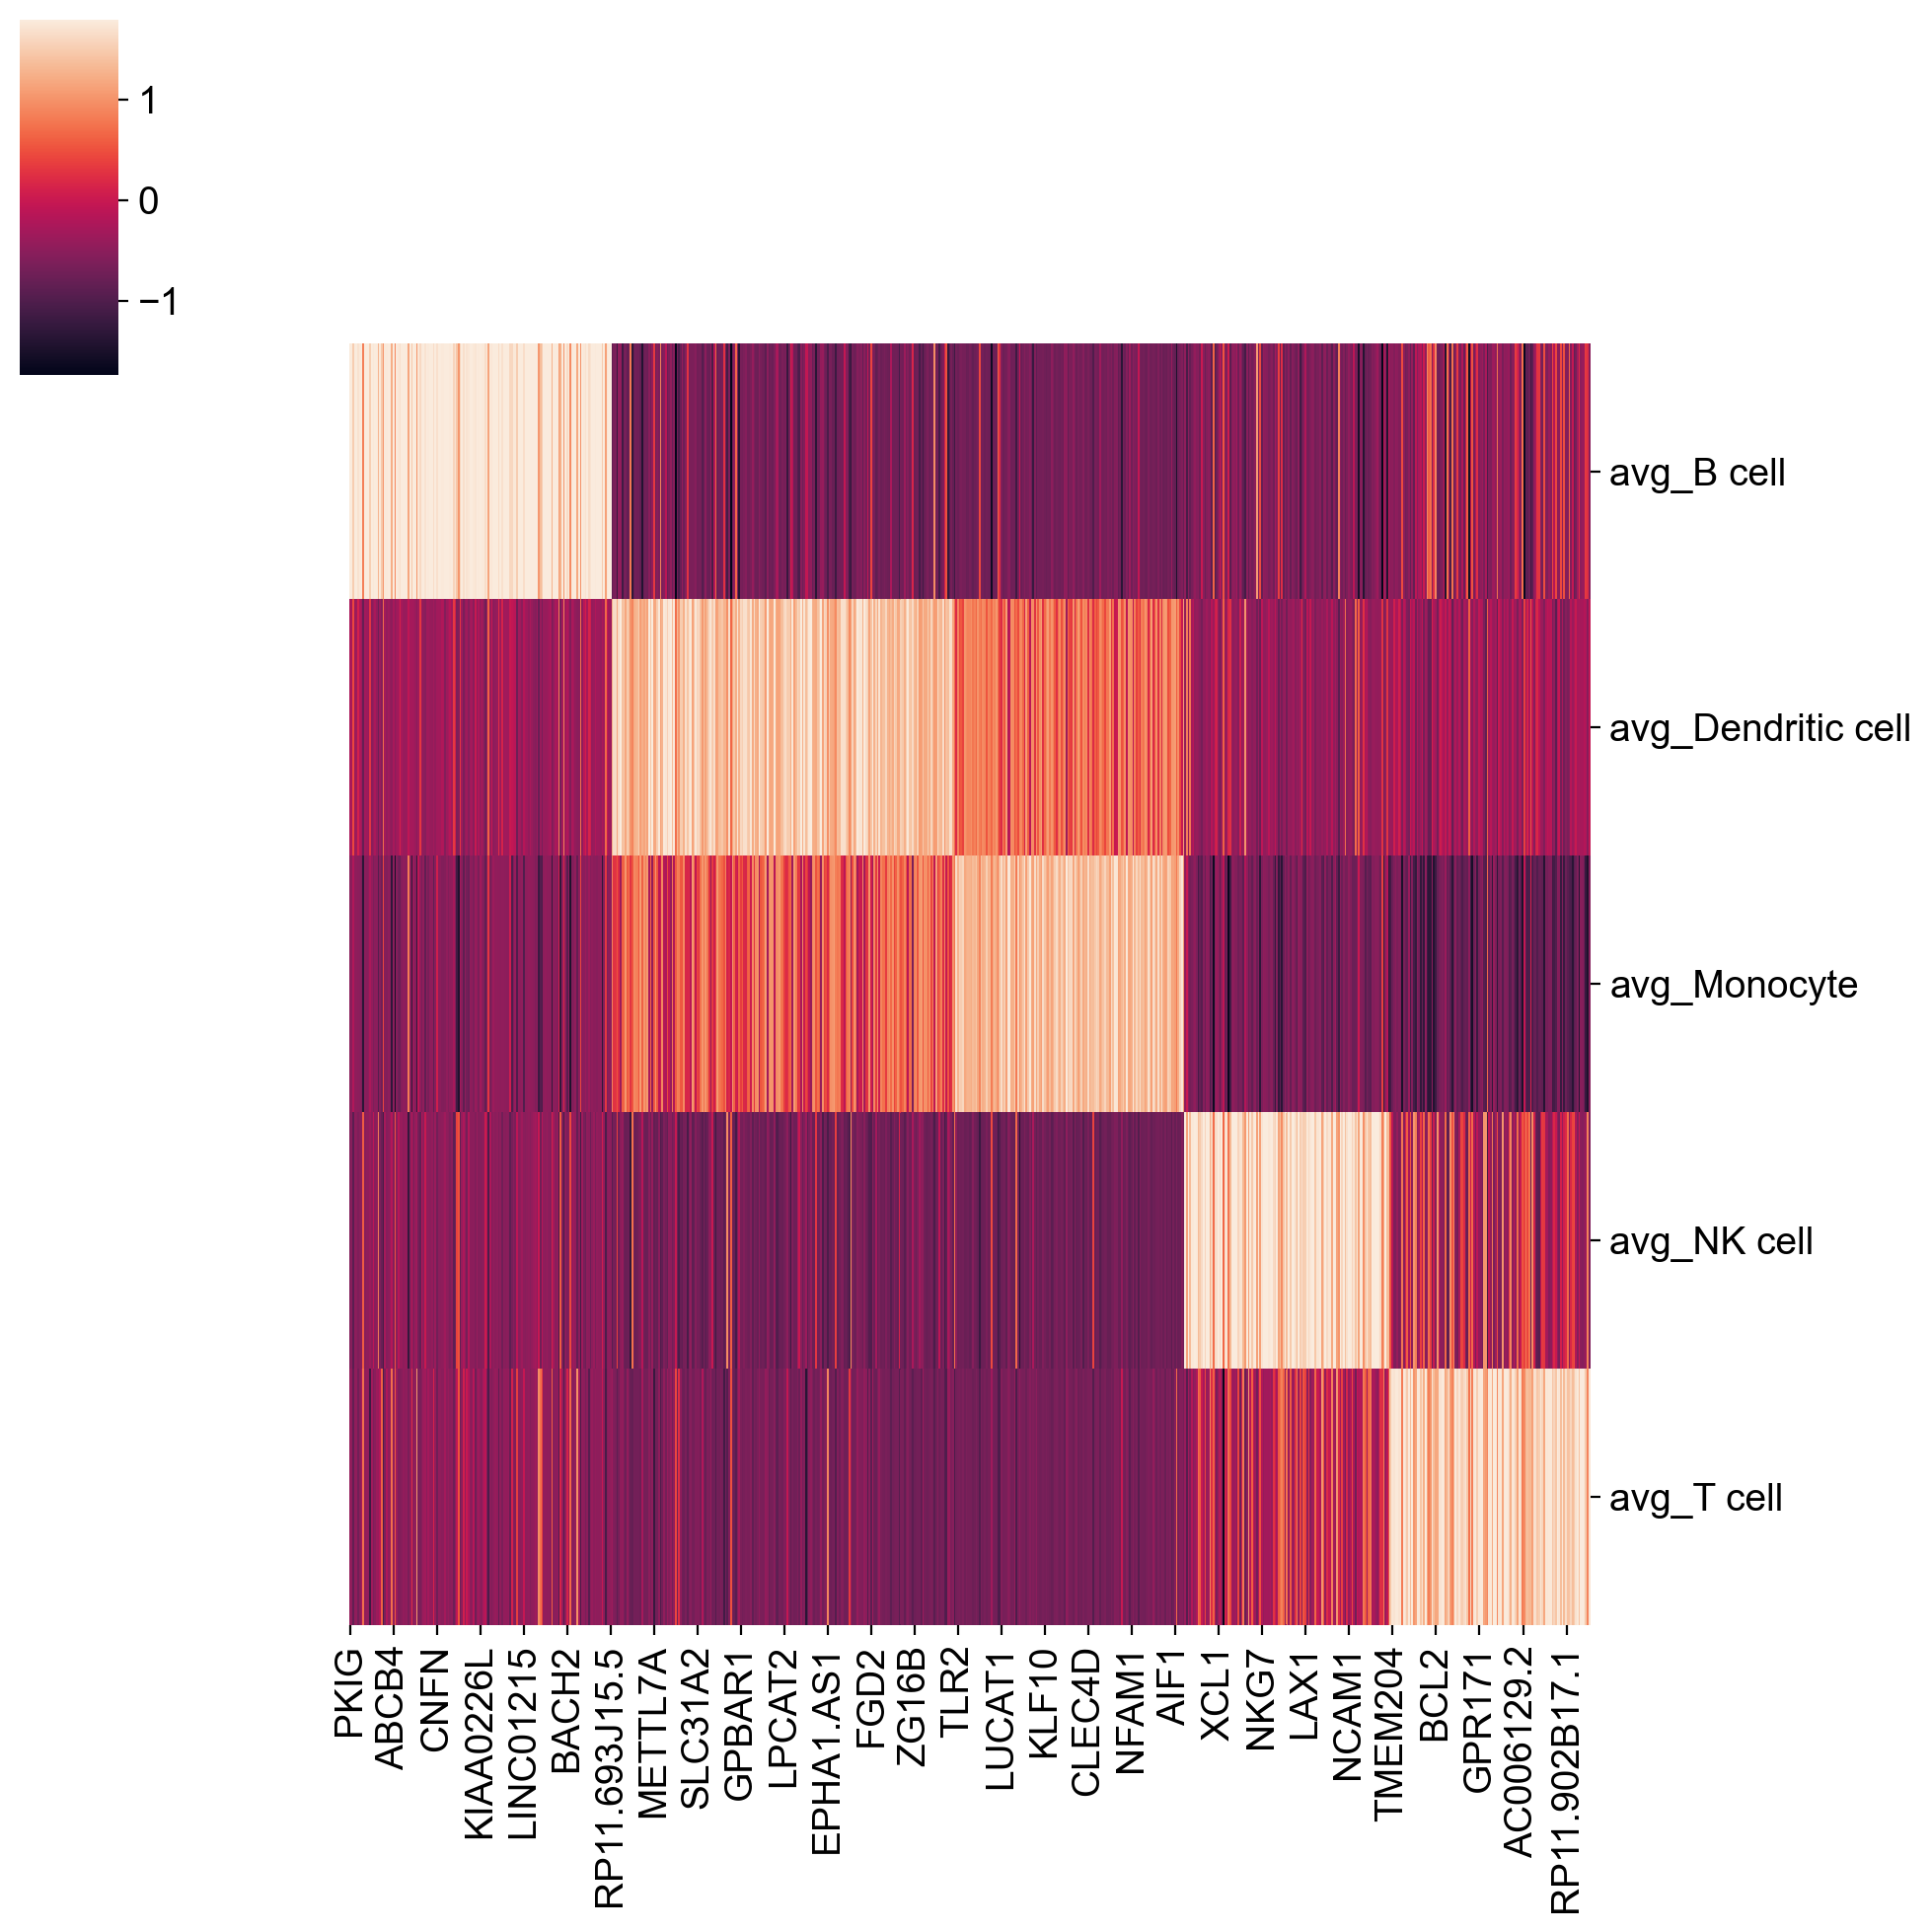

In [406]:
#plot signature matrix but sorted, here the light band in each cluster are highest expressed genes, so we can have a nicer looking plot
sig_matrix_tmp = sig_matrix.copy()

max_cluster_vec = list()
for g in list(sig_matrix.index):
    i = np.argmax(sig_matrix.loc[g])
    max_cluster_vec.append(i)
sig_matrix_tmp["max_cluster"] = max_cluster_vec
sig_matrix_sorted = sig_matrix_tmp.sort_values(by="max_cluster")
ax = sns.clustermap(sig_matrix_sorted.iloc[:,[0,1,2,3,4]].T, row_cluster = False, col_cluster=False, z_score = 1) 

## LM22 Signature matrixLM5_genes

In [393]:
LM5_overlap_genes = LM5_genes - (LM5_genes.difference(set(adata.raw.var_names)))

In [396]:
# average expression across annotation for raw data
res = pd.DataFrame(columns=adata.raw.var_names, index=adata.obs['cells'].cat.categories)                                                                                                 

for clust in adata.obs.cells.cat.categories: 
    res.loc[clust] = adata[adata.obs['cells'].isin([clust]),:].raw.X.mean(0)

# make sig matrix
sig_matrix = res[[*LM5_overlap_genes]].drop(['unknown'],axis=0).T
sig_matrix.columns = ["avg_" + cluster for cluster in sig_matrix.columns]
sig_matrix = sig_matrix.astype(float)
print(sig_matrix.shape)
sig_matrix.head()

(455, 5)


avg_B cell  avg_Dendritic cell  avg_Monocyte  avg_NK cell  \
KLRG1        0.083777            0.178874      0.056272     1.092691   
LINC00921    0.032363            0.076366      0.043051     0.058851   
VNN3         0.000000            0.014995      0.098940     0.000000   
APOL6        0.053256            0.568829      0.267437     0.479142   
CD37         2.463086            2.230574      1.905646     1.798914   

           avg_T cell  
KLRG1        0.522019  
LINC00921    0.045925  
VNN3         0.000467  
APOL6        0.300896  
CD37         1.932278

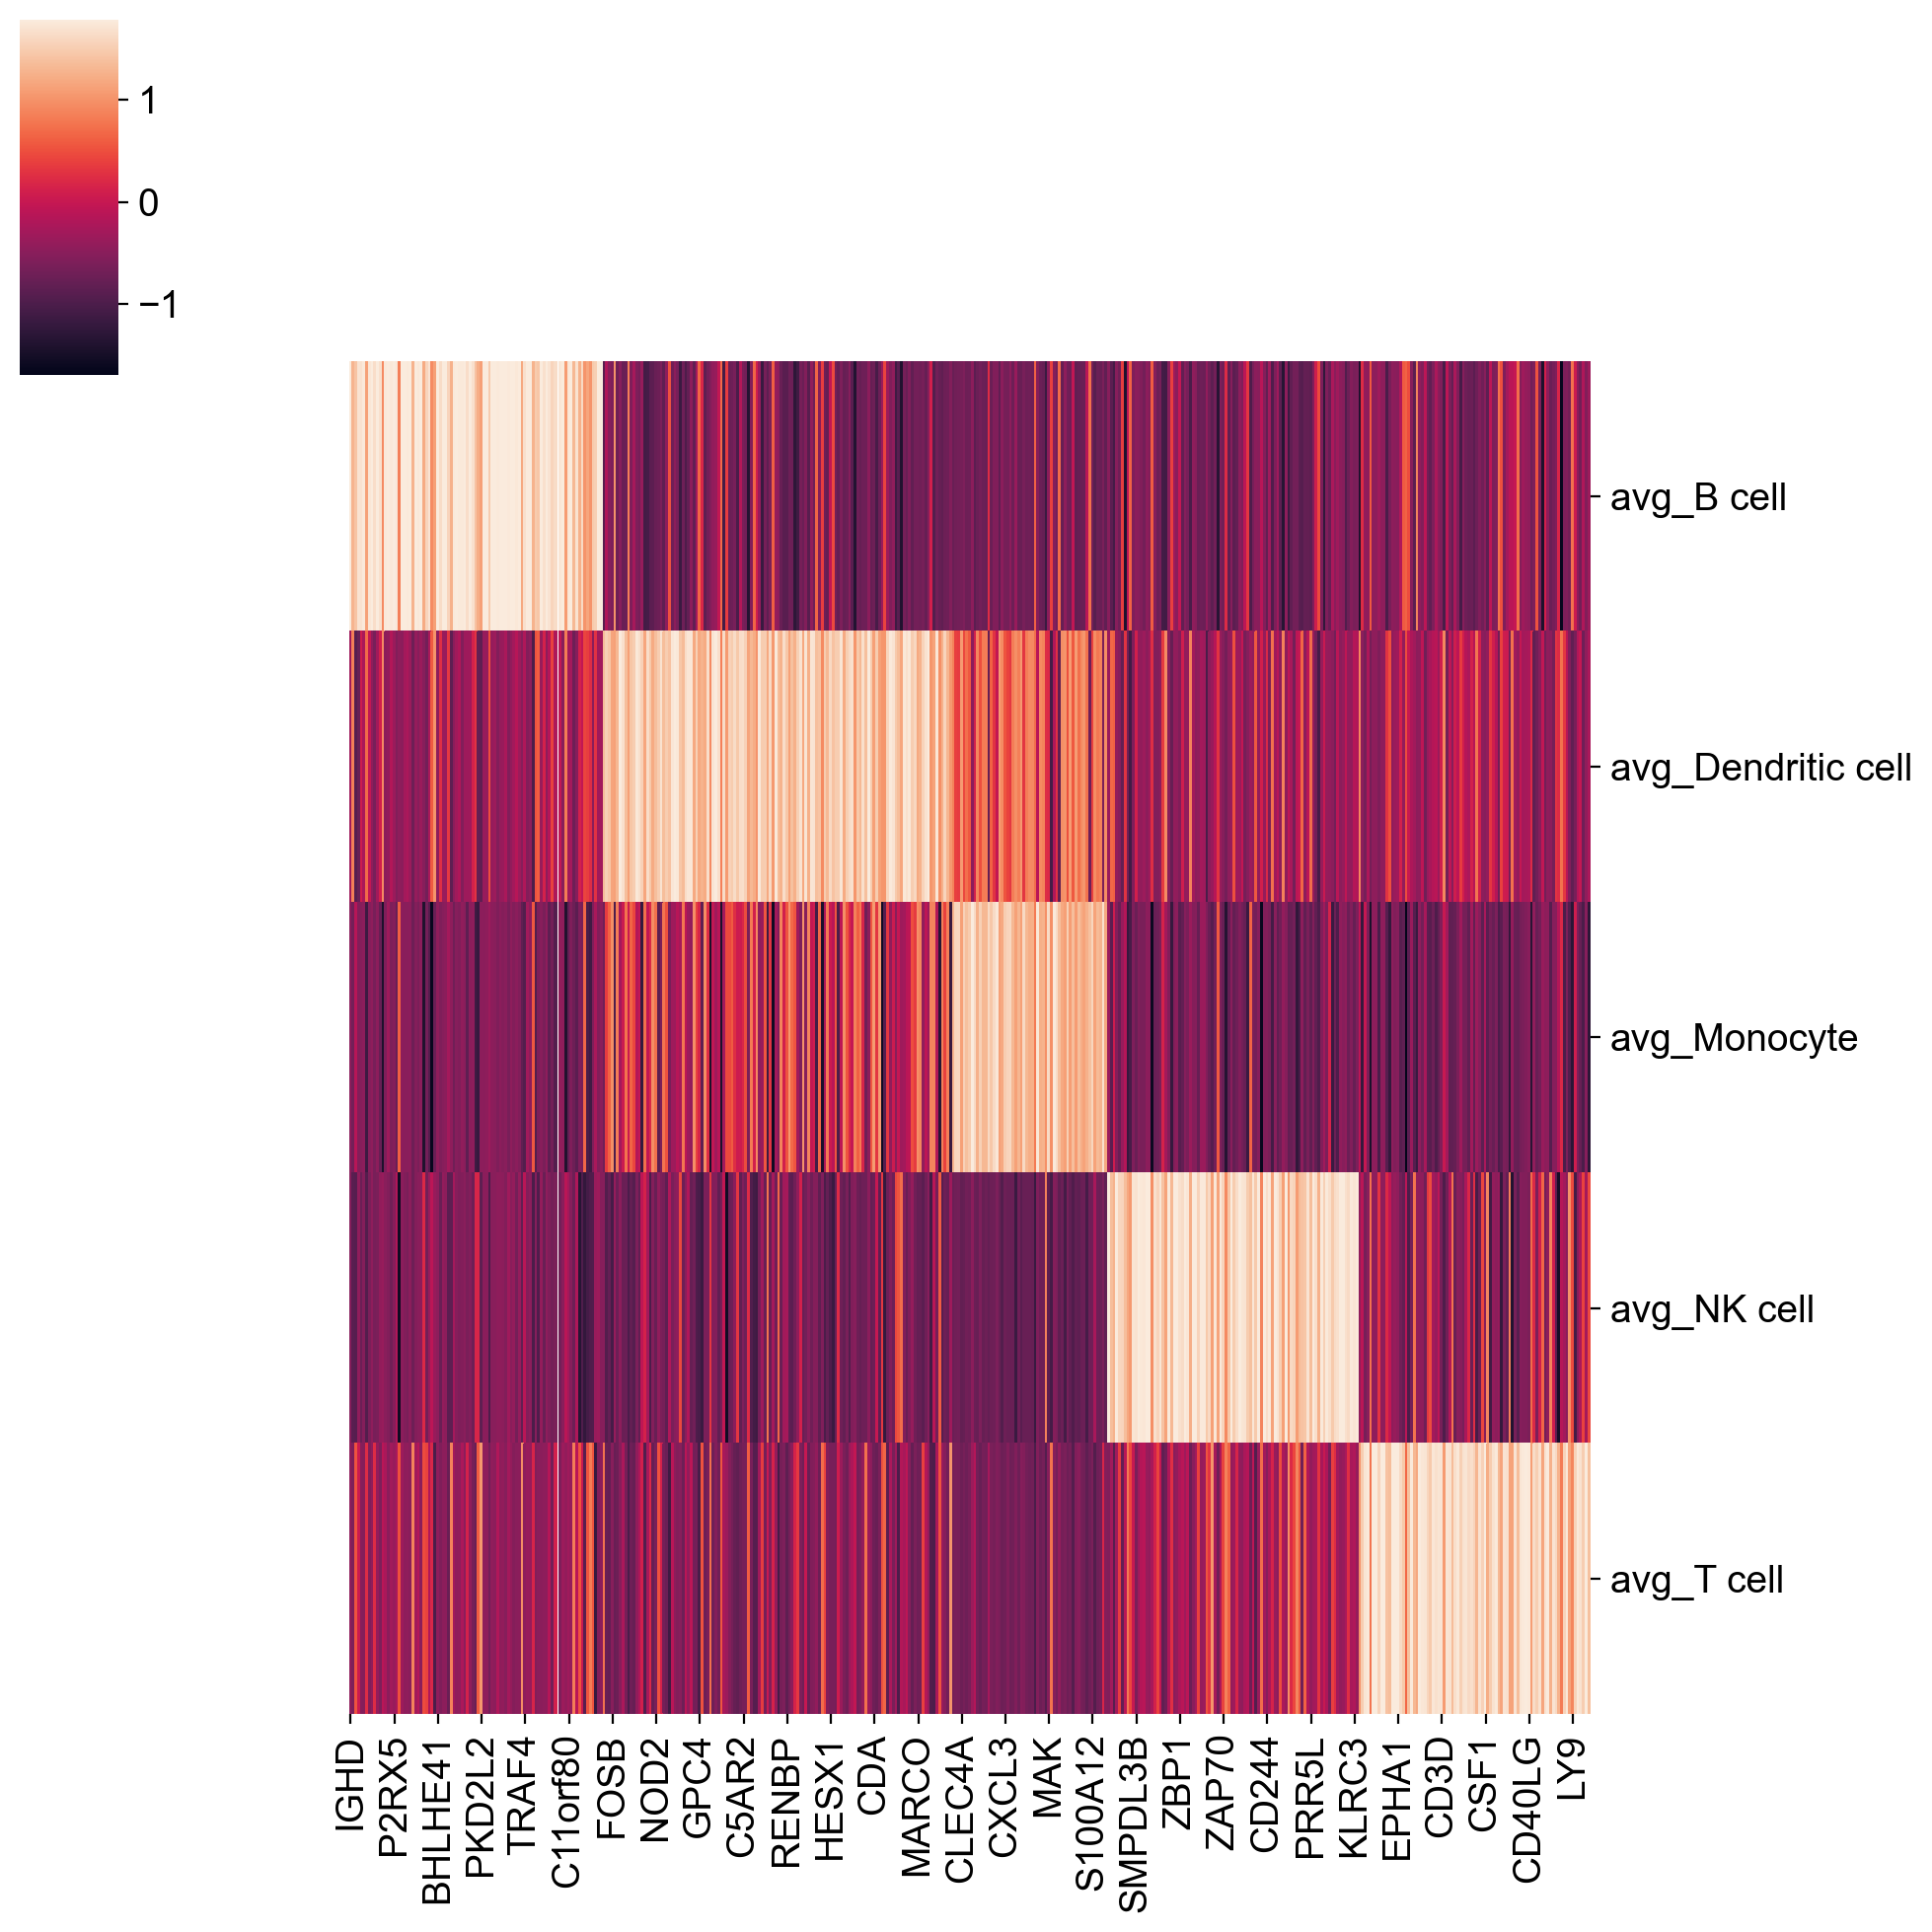

In [397]:
#plot signature matrix but sorted, here the light band in each cluster are highest expressed genes, so we can have a nicer looking plot
max_cluster_vec = list()
for g in list(sig_matrix.index):
    i = np.argmax(sig_matrix.loc[g])
    max_cluster_vec.append(i)
sig_matrix["max_cluster"] = max_cluster_vec
sig_matrix_sorted = sig_matrix.sort_values(by="max_cluster")
ax = sns.clustermap(sig_matrix_sorted.iloc[:,[0,1,2,3,4]].T, row_cluster = False, col_cluster=False, z_score = 1) 

# Files and Upload


In [10]:
sc.set_figure_params(dpi=600)

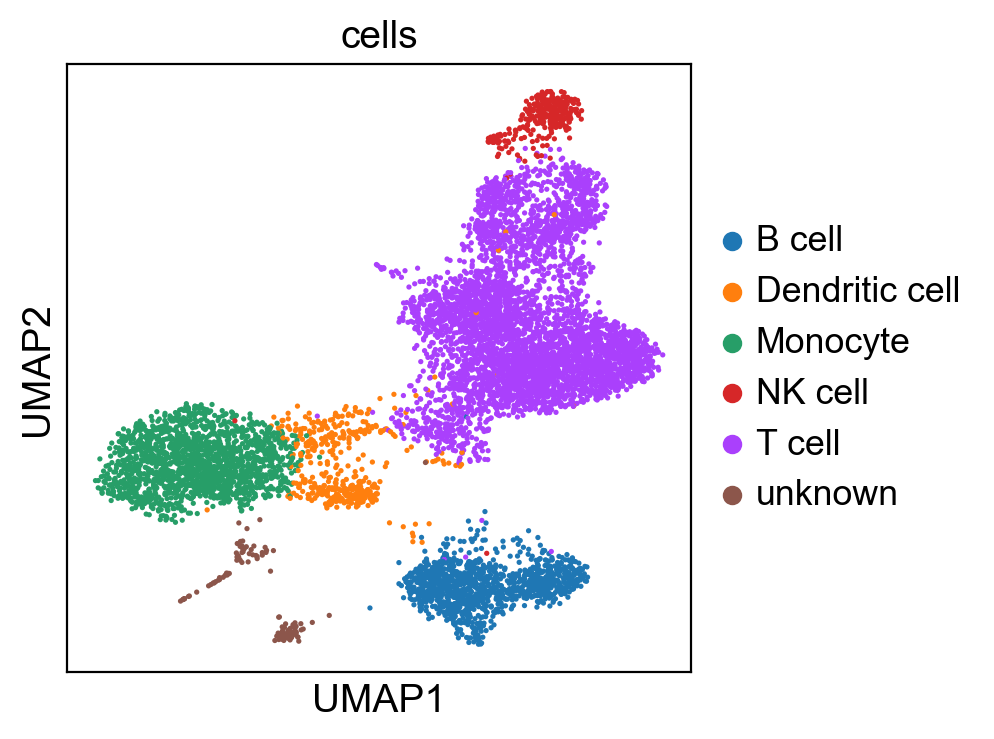

In [386]:
sc.pl.umap(adata, color='cells')